If running in a new enviroment, such as Google Colab, run this first.

In [13]:
# !git clone https://github.com/zach401/acnportal.git
# !pip install acnportal/.
# TODO: Force installation of tqdm?
# !pip install tqdm.

For this experiment, you will also need pandapower installed. Run the line of code below to install pandapower. We use pandapower 2.1.0 in this experiment.

In [14]:
# !pip install pandapower==2.1.0

# ACN-Sim Experiments: Pandapower Co-Simulation
## Implementing a Custom Algorithm
### by Sunash Sharma, Zachary Lee
#### Last updated: 11/06/2019

In this experiment, we use ACN-Sim in conjunction with pandapower to understand the effects of EV charging on the electrical grid. Specifically, we use outputs from simulations of the JPL ACN with different charging algorithms as inputs to a pandapower power flow at varying timesteps in a simple electrical grid. We experiment with adding EV charging to a grid already loaded with offices, and we try adding photovoltaic (PV) generation to our grid to offset the negative effects of EV charging on the grid. We also demonstrate a load-flattening objective to the Adacharge algorithm that attempts to reduce strain on the grid by adjusting EV charging based on external loads and generation.

In [15]:
import pandapower as pp
from pandapower import networks as pn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pytz
from datetime import datetime
from datetime import timedelta
from copy import deepcopy
from tqdm import tqdm

from acnportal import acnsim
from acnportal import algorithms

import pickle as pkl
import json
from io import StringIO

from adacharge import adacharge
import importlib
importlib.reload(adacharge)

<module 'adacharge.adacharge' from '/Users/sunash/Documents/schmidt/AdaCharge/adacharge/adacharge.py'>

## Loading and Processing Load/Generation Data

Before we do any simulation, we load in the generation and load data relevant for this experiment. We use the System Advisor Model (SAM) (https://sam.nrel.gov/) developed by the National Renewable Energy Laboratory (NREL) to simulate PV generation for year based on the typical meteorological year (TMY) in 2004 at JPL. We autosized the solar array using default settings (220 kWdc desired capacity). The resultant solar array had 219.586 kWdc and 179.580 kWac via a 1.22 DC/AC inverter. The SAM project file can be found at 
# TODO: Show where to find SAM project file
. Let's load in the generation data from SAM's simulation.

In [16]:
# TODO: These steps would probably be better of as utils removed from the tutorial.
# Load in PV Data -----------------------------------------------------------
# The year for which this data were simulated.
pv_year = 2004
# File name for pv data.
# TODO: Make sure this file is in the experiment directory.
pv_file_name = "results_jpl_autosized_220kWdc.csv"
# Read in PV data to a pandas DataFrame.
pv_data_full = pd.read_csv(pv_file_name, parse_dates=["Time stamp"])[["Time stamp", "Array DC power | (kW)"]]
# Add the year for conversion to datetime objects.
pv_data_full["Time stamp"] = ["{0} {1}".format(pv_year, pv_data_full["Time stamp"][i]) for i in range(len(pv_data_full["Time stamp"]))]
# Convert date strings to datetime objects in DataFrame.
# TODO: localizing this data to PST doesn't work due to a daylight savings time issue.
pv_data_full["Time stamp"] = pd.to_datetime(pv_data_full["Time stamp"])#.dt.tz_localize("America/Los_Angeles")
# Reindex based on datetime.
pv_data_full = pv_data_full.set_index("Time stamp")
# Rescale PV generation to AC capacity, convert to MW, and follow consumer-perspective sign convention (negative for generation)
pv_data_full["AC Power (MW)"] = -1 * pv_data_full["Array DC power | (kW)"] / 1.22 / 1000

We use data on building loads from the Office of Energy Efficiency & Renewable Energy (EERE) (https://openei.org/doe-opendata/dataset/commercial-and-residential-hourly-load-profiles-for-all-tmy3-locations-in-the-united-states). We use the medium office building load in the Burbank-Glendale-Pasadena file.

In [17]:
# Load in Medium Office Building Data -----------------------------------------------------
# The year for which this data were gathered.
load_year = 2004
# File name for load data.
# TODO: Make sure this file is in the experiment directory.
load_file_name = "RefBldgMediumOfficeNew2004_7.1_5.0_3B_USA_CA_LOS_ANGELES.csv"
# Read in load data to a pandas DataFrame.
load_data_full = pd.read_csv(load_file_name, parse_dates=["Date/Time"])[["Date/Time", "Electricity:Facility [kW](Hourly)"]]
# Add the year for conversion to datetime objects.
load_data_full["Date/Time"] = ["{0} {1}".format(load_year, load_data_full["Date/Time"][i]) for i in range(len(load_data_full["Date/Time"]))]

The building load data uses the 1-24 hour time format, so we must convert this to the 0-23 hour format to use datetime objects.

In [18]:
# Convert date strings to 0-23 hour format.
def convert_23_hr(time_lst):
    """Helper function to convert an index of 1-24 hour datetimes to 0-23 hour datetimes.
    
    Args:
        time_lst (List[str]): List of 1-24 hour datetime strings to convert to 0-23 hour datetimes.
    Returns:
        List[datetime]: List of 0-23 hour datetimes
    """
    # First move the last element to the beginning, as 12/31 24:00 is really 01/01 00:00.
    time_lst = time_lst[-1:] + time_lst[:-1]
    time_lst[0] = time_lst[0][0:4] + " 01/01 00:00:00"
    for idx, time in enumerate(time_lst):
        try:
            date_time = datetime.strptime(time, '%Y %m/%d %H:%M:%S')
            time_lst[idx] = date_time
        except ValueError:
            time = time.replace(" 24", " 00")
            date_time = datetime.strptime(time, '%Y %m/%d %H:%M:%S')
            date_time += timedelta(days=1)
            time_lst[idx] = date_time
    return time_lst
load_data_full["Date/Time"] = convert_23_hr(load_data_full["Date/Time"].tolist())
# convert date strings to datetime objects
load_data_full["Date/Time"] = pd.to_datetime(load_data_full["Date/Time"])
# convert loads to MW
load_data_full["Electricity:Facility [MW](Hourly)"] = load_data_full["Electricity:Facility [kW](Hourly)"]/1000
# reindex based on time
load_data_full = load_data_full.set_index("Date/Time")

Now let's combine the relevant columns of the load and PV dataframes into one PV/load dataframe.

In [19]:
# Combine load and generation data in MW into one dataframe.
pv_load_data_full = pd.concat([pv_data_full, load_data_full], axis=1)[["AC Power (MW)", "Electricity:Facility [MW](Hourly)"]]
pv_load_data_full.columns = ['PV Array (MW)', 'Medium Office (MW)']
# TODO: check which of loads or pv has the last datetime stamp
pv_load_data_full = pv_load_data_full.fillna(method='ffill')

## Running JPL ACN simulations

Now let us run simulations of adaptive charging on the JPL ACN. We'll first look at uncontrolled charging and earliest deadline first (EDF) algorithms. First, let's choose a weekday to simulate. Since we already have PV and load generations, we can look for two situations:

 1) The site has high generation and low load, meaning power is sent back to the grid \
 2) The site has low generation and high load, so power is drawn from the grid 
 
both of these cases may cause voltage and overload isues in the grid, but for this experiment let's look for a weekday satisfying the first case.

In [20]:
# Set net load/generation as a dataframe column. Recall generation is negative, hence the (+).
pv_load_data_full["Net from Grid (MW)"] = pv_load_data_full["Medium Office (MW)"] + pv_load_data_full["PV Array (MW)"]
# We want the weekday with the highest power sent back to the grid.
pv_load_data_full["Net from Grid (MW)"][(pv_load_data_full.index.weekday != 5) & (pv_load_data_full.index.weekday != 6)].idxmin()

Timestamp('2004-05-07 12:00:00')

May 7th was a weekday in both 2019 and 2004. Now let's run uncontrolled and EDF simulations. We'll use a simulation period of 5 (mins). First, let's define a function that builds and runs a simulation based on some configuration details.

In [21]:
def balanced_acn(basic_evse=True, voltage=208, transformer_cap=195,
    network_type=acnsim.ChargingNetwork):
    """ Generates a simple ACN which has all the same station ids as
    the JPL ACN, but with all EVSEs connected to one transformer and
    balanced (each EVSE is connected to all 3 lines).
    """
    jpl_stations = acnsim.sites.jpl_acn(basic_evse=True).station_ids
    if basic_evse: 
        evse_type = 'BASIC'
    else:
        evse_type = 'AV'
    return acnsim.sites.simple_acn(jpl_stations,
                                 evse_type=evse_type,
                                 voltage=voltage,
                                 aggregate_cap=transformer_cap,
                                 network_type=network_type)
    
# TODO: This might go in a utils module.
# TODO: How do we handle api key for published experiments?
def run_sim(sim_algorithm=algorithms.BaseAlgorithm, 
            alg_kwargs={}, API_KEY='DEMO_TOKEN', 
            site='caltech', start_date=datetime(2019, 1, 1), 
            end_date=datetime(2019, 1, 2), period=1, verbose=False, 
            timezone='America/Los_Angeles', basic_evse=True):
    """Builds and runs a simulation with the input configuration details.
    
    Args:
        sim_algorithm (acnsim.algorithms.BaseAlgorithm constructor or callable): Algorithm function with which to run the simulation, default BaseAlgorithm.
        alg_kwargs (Dict[str, object]): Keyword args input to the algorithm constructor, default {}.
        API_KEY (str): API key for generating events, default 'DEMO_TOKEN'.
        site (str): Site on which to run simulation, default 'caltech'.
        start_date (datetime.datetime): Start datetime for simulation, default 01/01/2019 00:00.
        end_date (datetime.datetime): End datetime for simulation, default 01/02/2019 00:00.
        period (int): Simulation period in minutes, default 1.
        verbose (bool): Outputs events if True, default False.
        timezone (str): Timezone to localize start/end times, default 'America/Los_Angeles'.
        basic_evse (bool): If true, use a basic continuous EVSE model rather than the realistic discrete models.
    
    Returns:
        (acnsim.Simulator): Simulator object that has been run with the input algorithm.
    """
    # -- Config ------------------------------------------------------------------------------------------------------------
    timezone = pytz.timezone(timezone)
    start = timezone.localize(start_date)
    end = timezone.localize(end_date)
    # TODO: this should be a network property.
    voltage = 208  # volts
    # TODO: make this a kwarg?
    default_battery_power = 32 * voltage / 1000 # kW
    
    # -- Network -----------------------------------------------------------------------------------------------------------
    # TODO: site registration (like OpenAI Gym does)
    site_dict = {'caltech': acnsim.sites.caltech_acn, 
                 'jpl': acnsim.sites.jpl_acn, 
                 'office001': acnsim.sites.office001_acn,
                 'balanced': balanced_acn}
    try:
        site_fn = site_dict[site]
    except KeyError:
        # TODO: SiteNotFound error class
        raise KeyError("Site {0} not found".format(site))
    cn = site_fn(basic_evse=basic_evse, voltage=voltage)

    # -- Events ------------------------------------------------------------------------------------------------------------
    events = acnsim.acndata_events.generate_events(API_KEY, 'jpl', start, end, period, voltage, default_battery_power)
    
    # -- Algorithm ---------------------------------------------------------------------------------------------------------
    # TODO: is there a better way to handle offline case?
    if 'offline' in alg_kwargs and alg_kwargs['offline'] == True:
        alg_kwargs['events'] = events
    sch = sim_algorithm(**alg_kwargs)
    
    # -- Simulation --------------------------------------------------------------------------------------------------------
    sim = acnsim.Simulator(deepcopy(cn), sch, deepcopy(events), start, period=period, verbose=verbose)
    sim.run()
    return sim

Now let's run simulations with the configurations we discussed before. We run an uncontrolled charging simulation and an earliest deadline first simulation.

In [22]:
# Define the static simulation parameters (start, end, site, period) as a config dict.
sim_year = 2019
sim_start = datetime(sim_year, 5, 7)
sim_end = datetime(sim_year, 5, 8)
sim_period = 5
sim_site = 'balanced'
config = {"start_date": sim_start, "end_date": sim_end, "period": sim_period, "site": sim_site}

# Simulate using uncontrolled charging.
sim_unc = run_sim(algorithms.UncontrolledCharging, **config)
# Simulate using the EDF algorithm.
sim_edf = run_sim(lambda: algorithms.SortedSchedulingAlgo(algorithms.earliest_deadline_first), **config)

## Load Flattening Simulations

For our next simulation, we attempt to make the scheduling algorithm responsive to the other loads on the site. For example, in periods of high building loads, the scheduler will avoid charging cars, whereas in periods of high PV generation, the scheduler will attempt to charge more cars. We may consider this algorithm a load flattening algorithm, in that the total load of the site on the grid (building load + PV generation + EV charging) is pushed toward 0 through control of the EV charging rate in response to the external load and generation.

# TODO: explain objective to Adacharge

If we want to run our load flattening algorithm, we must first input the correct signals. The load which must be flattened is the sum of PV generation and building load. Also, since the simulation period is 5 minutes, we must tile out the load/generation data, which currently has period 30 minutes.

In [23]:
# Make sure the load and generation years are equal, as otherwise flattening the total load is inaccurate.
assert pv_year == load_year
# Construct all relevant datetimes with sim_period increments for the load year.
base = pv_load_data_full.index[0]
date_series = pd.date_range(base, pv_load_data_full.index[-1], freq="{0}min".format(sim_period))
# Reindex pv/load data with new, finer index and forward-fill NaN's. 
pv_load_data_full = pv_load_data_full.reindex(date_series).fillna(method='ffill')

Now we can input the load data to the simulation as numpy arrays. We need to start the array at the timestamp when the simulation starts (May 7th at 12 AM). Also, let's run 3 cases for the external load:
 
 * PV generation only
 * Building load only
 * Building load + PV generation 

In [24]:
# Get building, PV, and combined load from the simulation start date onwards, as numpy arrays.
pv_load_start = sim_start.replace(year=load_year)
pv_arr = pv_load_data_full["PV Array (MW)"][pv_load_start:]
load_arr = pv_load_data_full["Medium Office (MW)"][pv_load_start:]
pv_load_arr = pv_load_data_full["Net from Grid (MW)"][pv_load_start:]

ada_config = {'energy_equality': False, 'units': 'MW'}

sim_lf_pv = run_sim(adacharge.AdaChargeLoadFlatteningDiscounted, 
    alg_kwargs={**{'external_signal': pv_arr}, **ada_config}, **config)
sim_lf_load = run_sim(adacharge.AdaChargeLoadFlatteningDiscounted, 
    alg_kwargs={**{'external_signal': load_arr}, **ada_config}, **config)
importlib.reload(adacharge)
sim_lf_pv_load = run_sim(adacharge.AdaChargeLoadFlatteningDiscounted, 
    alg_kwargs={**{'external_signal': pv_load_arr}, **ada_config}, **config)
sim_lf_pv_load_offline_optimal = run_sim(adacharge.AdaChargeLoadFlatteningDiscounted, 
    alg_kwargs={**{'external_signal': pv_load_arr}, **ada_config, 'offline': True}, **config)

0.9999999246293877


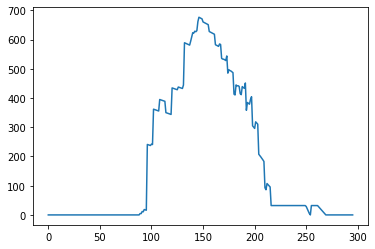

In [25]:
plt.plot(acnsim.aggregate_current(sim_lf_pv_load))
print(acnsim.proportion_of_energy_delivered(sim_lf_pv_load))

Finally, let's compile the aggregate currents from the simulations into a dataframe for ease of access, along with the building load and PV generation.

In [26]:
# DataFrame for all simulation and load data. Simulation data is the aggregate current over time.
all_results = pd.DataFrame(columns=["Medium Office Load", "PV Generation", "Combined Loads", "Uncontrolled Charging", "EDF Charging", "Load Flattening: PV", "Load Flattening: Load", "Load Flattening: Combined"])

# We will cut off load and generation after sim_len timesteps.
sim_len = len(acnsim.aggregate_current(sim_unc))
load_trunc = load_arr[:sim_len]
pv_trunc = pv_arr[:sim_len]
pv_load_trunc = pv_load_arr[:sim_len]

# Set load/generation data
for column, data in zip(all_results.columns[:3], [load_trunc, pv_trunc, pv_load_trunc]):
    all_results[column] = data

# Set simulation data (converting amps to MW)
for column, sim in zip(all_results.columns[3:], [sim_unc, sim_edf, sim_lf_pv, sim_lf_load, sim_lf_pv_load]):
    all_results[column] = acnsim.aggregate_current(sim) * 208 / 1000000

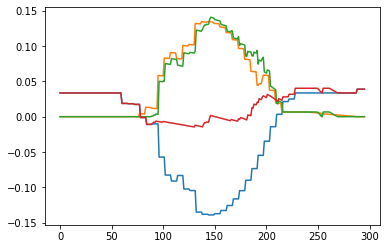

In [27]:
plt.plot(pv_load_trunc.to_numpy())
plt.plot(acnsim.aggregate_current(sim_lf_pv_load_offline_optimal) * 208 / 1000000)
plt.plot(all_results["Load Flattening: Combined"].to_numpy())
plt.plot((all_results["Combined Loads"] + all_results["Load Flattening: Combined"]).to_numpy())

## Using Pandapower for Grid Evaluation

We can analyze the results of our simulations in the larger context of the electrical grid. Let's take the perspective of a system designer who wants to add EV charging to some sites without straining the rest of the electrical grid. Say the grid is configured like the Pandapower small branches-out test network, given at https://pandapower.readthedocs.io/en/v2.1.0/networks/test.html. We start with a medium office building load on each of the four loads in the network. Pandapower power flows are static evaluations, so we will conduct a power flow at each timestep to understand how the grid behaves in time. First, some functions to help us construct the network, assign its loads, and run power flows. To avoid having to change the test case from the pandapower specification, we divide all loads by 2, which doesn't change relative load sizes and so is acceptable for the purposes of this study.

In [28]:
def create_network():
    """Creates a small branches-out test network with active and reactive power set to 0.
    
    Returns:
        pandapower.auxiliary.pandapowerNet: Output network.
    """
    small_network = pn.four_loads_with_branches_out()
    small_network.load["p_mw"] = 0
    small_network.load["q_mvar"] = 0
    return small_network

def assign_loads(network, load_val, loads=None):
    """In network, assigns load_val as the active power for the loads specified in loads, or to all loads if loads=None.
    
    Args:
        network (pandapower.auxiliary.pandapowerNet): Pandapower network on which to add loads.
        load_val (number): Load to assign to the p_mw (active power) field.
        loads (List[int]): Load indices for which to assign load_val as the active power. If None, assign load_val to all loads.
    
    Returns:
        None.
    """
    if loads is None:
        loads = network.load.index.tolist()
    network.load["p_mw"][loads] = load_val

def time_var_power_flow(load_results, n_timesteps, load_func):
    """Runs a power flow on the branches out network, for n_timesteps iterations, using load_func to generate loads to assign
    from the load_results DataFrame.
    
    Args:
        load_results (pd.DataFrame): a DataFrame with various loads/generations over time.
        n_timesteps (int): number of timesteps for which to run the power flow.
        load_func (pd.DataFrame, int -> number): a function that calculates a load from a DataFrame of loads and a timestep
    
    Returns:
        List[pandapower.auxiliary.pandapowerNet]: List of output networks (with power flow results) at each time step.
    """
    
    
    # Store output networks (with power flow results) in a list
    power_flows = []
    for i in tqdm(range(0, n_timesteps, 1)):
        load_val = load_func(load_results, i)/2
        curr_net = create_network()
        assign_loads(curr_net, load_val)
        # Save initial network state for deubbinging purposes.
        snapshot = curr_net
        # TODO: Once the experiment works, remove try-except block.
        try:
            pp.runpp(curr_net)
        except:
            print(i)
            diag_results = pp.diagnostic(snapshot, overload_scaling_factor=0.5)
            print(diag_results)
            input("Press any key to continue.")
        power_flows.append(curr_net)
    return power_flows

Now let's run an initial power flow, that assumes only building loads are present (i.e. before we've installed any EVs)

In [31]:
pf_loads = time_var_power_flow(all_results, sim_len,
                               lambda res, t: res["Medium Office Load"][t])

100%|██████████| 296/296 [00:52<00:00,  5.61it/s]


Let's see what the voltage on the last bus, farthest from the external grid (which would have the highest voltage difference from nominal out of all the buses).

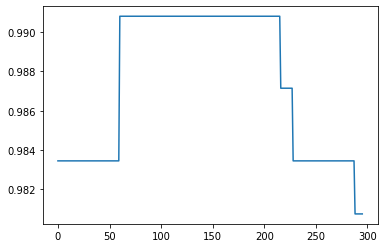

In [32]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)])

We can see that at worst, we are 2% below the nominal voltage. Let's also look at transformer utilization.

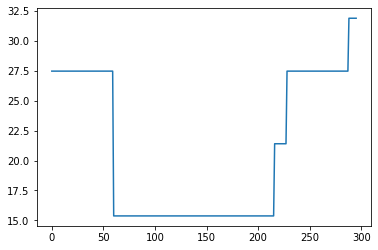

In [33]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

We are well under 50% utilization. Now let's add in level 2 uncontrolled EV charging, modeled after the JPL charging network.

In [34]:
pf_loads_unc = time_var_power_flow(all_results, sim_len,
                              lambda res, t: res["Medium Office Load"][t] + res["Uncontrolled Charging"][t])

100%|██████████| 296/296 [00:49<00:00,  5.96it/s]


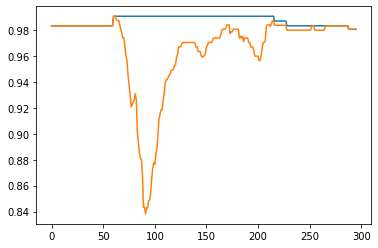

In [35]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)])

By adding uncontrolled EV charging, we have dropped drastically below the nominal voltage, over 16% lower. What about our transformer utilization?

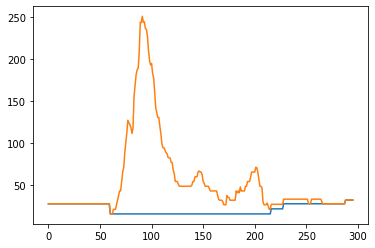

In [36]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

We are overutilizing the transformer by 150% percent. Clearly, our grid is in no way equipped to handle EV charging on the desired scale if the charging is uncontrolled. Let's now try adding in charge scheduling to avoid violating network infrastructure constraints and hopefully lessen the burden on the grid.

In [37]:
pf_loads_edf = time_var_power_flow(all_results, sim_len,
                              lambda res, t: res["Medium Office Load"][t] + res["EDF Charging"][t])

100%|██████████| 296/296 [00:52<00:00,  5.68it/s]


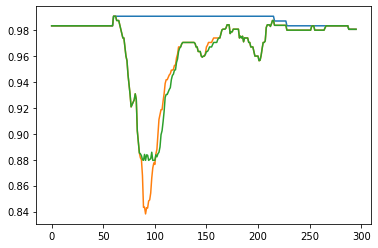

In [38]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)])

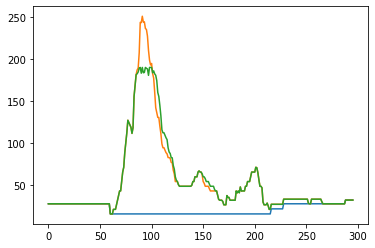

In [39]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_edf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

We see we're slightly kinder to the grid, but we still have over a 10% voltage drop and 75% transformer over-utilization, both of which are unacceptable. Scheduling on its own does not seem to sufficiently mitigate the effect of EV charging on the grid. So, let's try using onsite solar generation to offset some of the load on the grid.

In [40]:
pf_loads_pv_edf = time_var_power_flow(all_results, sim_len,
                              lambda res, t: res["Medium Office Load"][t] + res["EDF Charging"][t] + res["PV Generation"][t])

100%|██████████| 296/296 [00:50<00:00,  5.90it/s]


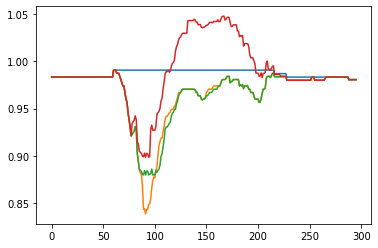

In [41]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)])
plt.plot([pf_loads_pv_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)])

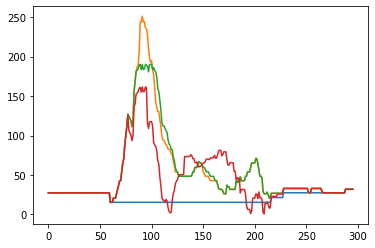

In [42]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_edf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_pv_edf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

Interestingly, solar does not seem to help the grid as much as we might expect. The peak voltage drop is still near 10%, and the transformer is still over-utilized by 50%. Even worse, we now have over-voltage issues, which in some locales is a larger concern than under-voltage: around midday, when many of the cars are done charging but solar is at its peak, we see a voltage that is 5% over nominal. As one may expect, these problems occur because there is a mismatch between the times at which peak EDF charging and peak solar occur. Fortunately, we have a way to encourage EV charging during times of peak solar: load flattening. If a linear optimization encourages total load to be 0, the resultant schedule will charge EVs at high rate when solar is at high generation, and keep charging low when solar isn't as available, and when building load is higher. Let's see how well theory translates to practice in this case:

In [43]:
pf_loads_pv_lf = time_var_power_flow(all_results, sim_len,
                              lambda res, t: res["Medium Office Load"][t] + res["Load Flattening: Combined"][t] + res["PV Generation"][t])

100%|██████████| 296/296 [00:50<00:00,  5.90it/s]


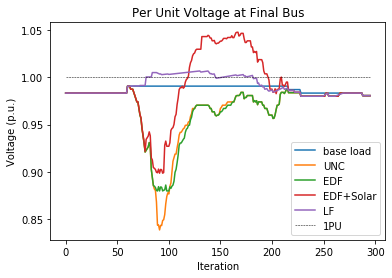

In [44]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='base load')
plt.plot([pf_loads_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='UNC')
plt.plot([pf_loads_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='EDF')
plt.plot([pf_loads_pv_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='EDF+Solar')
plt.plot([pf_loads_pv_lf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='LF')
plt.plot(np.ones((sim_len,)), "black", linestyle='--', linewidth=0.5,
         label='1PU')
plt.legend(loc='lower right')
plt.title("Per Unit Voltage at Final Bus")
plt.xlabel("Iteration")
plt.ylabel("Voltage (p.u.)")
plt.savefig("vm_pu_all.png")

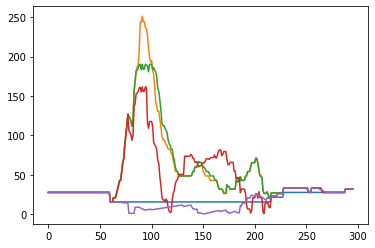

In [45]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_unc[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_edf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_pv_edf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_pv_lf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

We see great results! Our under-voltage issues are definitely gone (or at least at the same level as before we installed EV charging) and our transformer utilization is clearly lower. Let's look closer at how these results compare to our original, EV-free results.

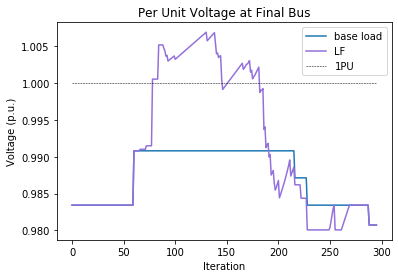

In [46]:
plt.plot([pf_loads[i].res_bus["vm_pu"][9] for i in range(sim_len)],
         label="base load")
plt.plot([pf_loads_pv_lf[i].res_bus["vm_pu"][9] for i in range(sim_len)],
         "mediumpurple", label="LF")
plt.plot(np.ones((sim_len,)), "black", linestyle='--', linewidth=0.5,
         label='1PU')
plt.legend(loc='upper right')
plt.title("Per Unit Voltage at Final Bus")
plt.xlabel("Iteration")
plt.ylabel("Voltage (p.u.)")
plt.savefig("vm_pu_lf_only.png")

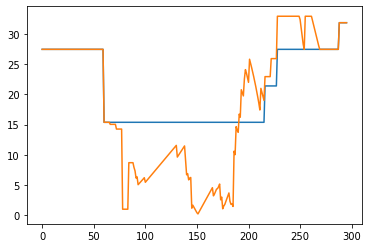

In [47]:
plt.plot([pf_loads[i].res_trafo["loading_percent"][0] for i in range(sim_len)])
plt.plot([pf_loads_pv_lf[i].res_trafo["loading_percent"][0] for i in range(sim_len)])

Indeed, voltage-wise we are at most 2% under and 1% over, well within the bounds required by most grids. Our average transformer utilization is better than building load only, and our peak utilization is only about 3% higher than pre-EV. Finally, one may be concerned that load-flattening may have decreased the strain on the grid by trading off how many people were fully charged before they left. Let's see if this is the case:

In [48]:
acnsim.proportion_of_energy_delivered(sim_lf_pv_load)

0.9999999246293877

So, we made no sacrifices here: everyone received their desired energy on time.

# TODO: Issues
 * Simulations only run for a single day with high PV generation and almost no building load. We should try the opposite extreme.
 * Currently I don't have a good reason for dividing all loads by 2 except to ensure convergence.
 * In terms of presentation I think it would be better to pair each simulation with a power flow instead of running all simulations and then all power flows.
 * There's another story in which PV and building load are already there and we use EVs to offset over-generation.
 * All the graphs need labels/legends

In [49]:
pf_loads_pv_unc = time_var_power_flow(all_results, sim_len,
                              lambda res, t: res["Medium Office Load"][t] + res["Uncontrolled Charging"][t] + res["PV Generation"][t])

100%|██████████| 296/296 [00:49<00:00,  5.95it/s]


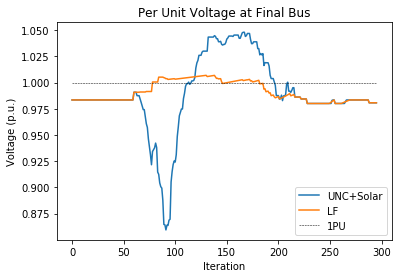

In [51]:
plt.plot([pf_loads_pv_unc[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='UNC+Solar')
#plt.plot([pf_loads_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
#         label='EDF')
#plt.plot([pf_loads_pv_edf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
#         label='EDF+Solar')
plt.plot([pf_loads_pv_lf[i].res_bus["vm_pu"][9] for i in range(sim_len)], 
         label='LF')
plt.plot(np.ones((sim_len,)), "black", linestyle='--', linewidth=0.5,
         label='1PU')
plt.legend(loc='lower right')
plt.title("Per Unit Voltage at Final Bus")
plt.xlabel("Iteration")
plt.ylabel("Voltage (p.u.)")
plt.savefig("vm_pu_all.png")